In [1]:
# import pandas as pd
# df_tickers = pd.read_csv("biotech_tickers.csv")
# unique_tickers_list = df_tickers.Ticker.unique().tolist()
# unique_tickers_list

2024-10-14 09:42:11,701 - ERROR - APGE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:21,161 - ERROR - CGON: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
2024-10-14 09:42:21,679 - ERROR - GPCR: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:23,046 - ERROR - NMRA: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:33,517 - ERROR - FTRE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
2024-10-14 09:42:45,858 - ERROR - BCAX: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
2024-10-14 09:42:46,164 - WARNING - No financial data for BCAX.
2024-10-14 09:42:53,323 - ERROR - AVBP: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', '

                Strategy  Sharpe Ratio  \
0         Short Strategy     -0.800888   
1  Buy and Hold Strategy      0.228921   

                                        Max Drawdown  
0  [0.9793867888564044, 0.9793867888564044, 0.979...  
1  [2.4308644123813066, 2.4308644123813066, 2.369...  


<Figure size 1000x600 with 0 Axes>

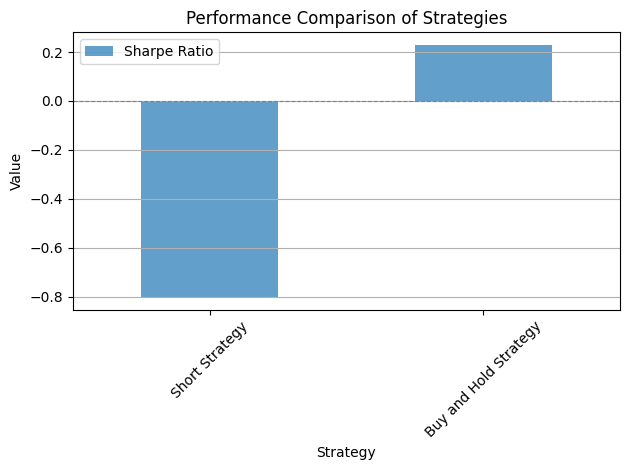

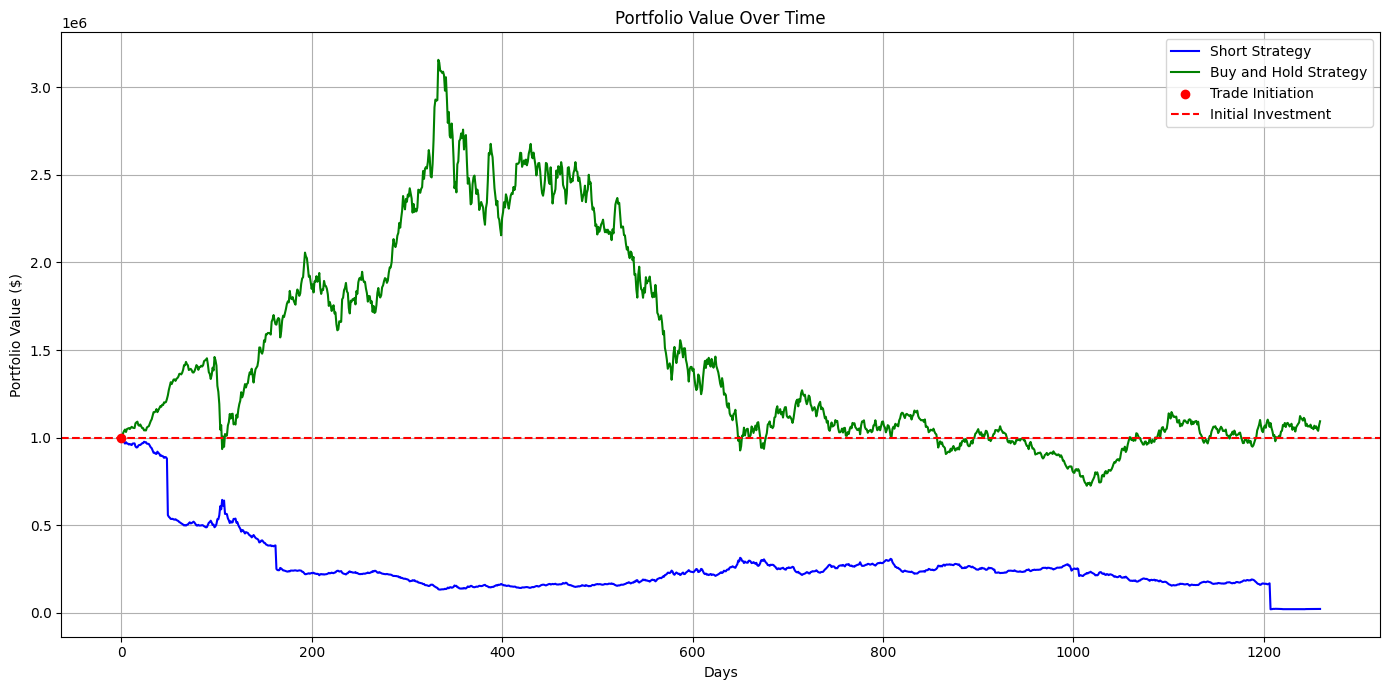

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

df_tickers = pd.read_csv("biotech_tickers.csv")
unique_tickers_list = df_tickers.Ticker.unique().tolist()
unique_tickers_list

# Fetch stock data function
def fetch_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="5y")

        # Fetch quarterly financial metrics
        quarterly_info = stock.quarterly_financials.T
        balance_sheet_info = stock.quarterly_balance_sheet.T
        
        if quarterly_info.empty or balance_sheet_info.empty:
            logging.warning(f"No financial data for {ticker}.")
            return None, None
        
        quarters_data = []
        for date in quarterly_info.index:
            revenue = quarterly_info.get('Total Revenue', pd.Series()).get(date, np.nan)
            net_income = quarterly_info.get('Net Income', pd.Series()).get(date, np.nan)
            total_assets = balance_sheet_info.get('Total Assets', pd.Series()).get(date, np.nan)
            total_liabilities = balance_sheet_info.get('Total Liabilities Net Minority Interest', pd.Series()).get(date, np.nan)
            
            shareholder_equity = total_assets - total_liabilities if total_assets and total_liabilities else np.nan
            
            quarters_data.append({
                'ticker': ticker,
                'fetched_date': datetime.now().date(),
                'latest_quarter': date,
                'revenue': revenue,
                'net_income': net_income,
                'total_assets': total_assets,
                'total_liabilities': total_liabilities,
                'shareholder_equity': shareholder_equity,
            })

        return hist['Close'].dropna(), quarters_data
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        return None, None

# List of biotech tickers
biotech_tickers = unique_tickers_list #['AMGN', 'GILD', 'VRTX', 'REGN', 'BIIB']

# Fetch historical data and financial metrics
close_data = []
financial_data = []
for ticker in biotech_tickers:
    adjusted_close, quarters_data = fetch_stock_data(ticker)
    if adjusted_close is not None:
        close_data.append(adjusted_close.to_frame(name=ticker))
        financial_data.extend(quarters_data)

price_close_df = pd.concat(close_data, axis=1)
financial_df = pd.DataFrame(financial_data)

# Determine stocks to short based on debt-to-equity ratio
def determine_shorts(financial_df):
    financial_df['debt_to_equity'] = financial_df['total_liabilities'] / financial_df['shareholder_equity']
    top_20_percent_debt_to_equity = financial_df['debt_to_equity'].quantile(0.8)
    shorts_candidates = financial_df[financial_df['debt_to_equity'] > top_20_percent_debt_to_equity]
    return shorts_candidates['ticker'].unique()

# Shorting strategy backtest
short_tickers = determine_shorts(financial_df)
initial_investment = 1_000_000

def backtest_short_strategy(price_close_df, short_tickers):
    portfolio_value = initial_investment
    daily_returns = price_close_df.pct_change().fillna(0)
    
    shorted_returns = daily_returns[short_tickers]
    num_shorts = len(short_tickers)
    allocation_per_stock = portfolio_value / num_shorts if num_shorts > 0 else 0

    portfolio_values_short = [portfolio_value]

    for date in shorted_returns.index:
        if date in shorted_returns.index:
            daily_portfolio_return = (shorted_returns.loc[date] * -1).mean()  # Shorting profits when prices fall
            portfolio_value *= (1 + daily_portfolio_return)
            portfolio_values_short.append(portfolio_value)

    return portfolio_values_short

def backtest_buy_and_hold(price_close_df):
    initial_prices = price_close_df.iloc[0]
    buy_hold_values = [initial_investment]
    
    for date in price_close_df.index:
        current_prices = price_close_df.loc[date]
        returns_per_stock = current_prices / initial_prices - 1
        average_return_per_stock = returns_per_stock.mean()
        
        current_portfolio_value_buy_hold = initial_investment * (1 + average_return_per_stock)
        buy_hold_values.append(current_portfolio_value_buy_hold)

    return buy_hold_values

def calculate_performance_metrics(portfolio_values):
    daily_returns = np.array(portfolio_values[1:]) / np.array(portfolio_values[:-1]) - 1
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
    return sharpe_ratio, max_drawdown

if len(short_tickers) > 0:
    portfolio_values_short = backtest_short_strategy(price_close_df, short_tickers)
    buy_hold_values_over_time = backtest_buy_and_hold(price_close_df)
    
    # Calculate performance metrics
    short_sharpe, short_max_drawdown = calculate_performance_metrics(portfolio_values_short)
    buy_hold_sharpe, buy_hold_max_drawdown = calculate_performance_metrics(buy_hold_values_over_time)

    # Create a summary DataFrame for statistics
    performance_df = pd.DataFrame({
        'Strategy': ['Short Strategy', 'Buy and Hold Strategy'],
        'Sharpe Ratio': [short_sharpe, buy_hold_sharpe],
        'Max Drawdown': [short_max_drawdown, buy_hold_max_drawdown]
    })

    # Display performance statistics as a table
    print(performance_df)

    # Visualization: Bar plot for Sharpe Ratio and Max Drawdown
    plt.figure(figsize=(10, 6))
    performance_df.set_index('Strategy').plot(kind='bar', alpha=0.7)
    plt.title('Performance Comparison of Strategies')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plotting portfolio value over time for both strategies
    plt.figure(figsize=(14, 7))
    
    plt.plot(portfolio_values_short, label='Short Strategy', color='blue')
    plt.plot(buy_hold_values_over_time, label='Buy and Hold Strategy', color='green')
    
    plt.scatter([0], [initial_investment], color='red', label='Trade Initiation', zorder=5)

    plt.title('Portfolio Value Over Time')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.axhline(y=initial_investment, color='red', linestyle='--', label='Initial Investment')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    logging.warning("No tickers were selected for shorting based on the criteria.")


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import logging
from concurrent.futures import ThreadPoolExecutor

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load biotech tickers
df_tickers = pd.read_csv("biotech_tickers.csv").head(10)
unique_tickers_list = df_tickers['Ticker'].unique().tolist()

# Fetch stock data function
def fetch_stock_data(ticker):
    stock_data = {
        'ticker': ticker,
        'debt_to_equity': np.nan,
        'current_ratio': np.nan,
        'gross_margin': np.nan,
        'net_margin': np.nan,
        'share_issuance': np.nan,
        'convertible_outstanding': np.nan,
    }
    try:
        stock = yf.Ticker(ticker)
        
        # Fetch quarterly financial metrics
        quarterly_info = stock.quarterly_financials.T
        balance_sheet_info = stock.quarterly_balance_sheet.T
        
        if quarterly_info.empty or balance_sheet_info.empty:
            logging.warning(f"No financial data for {ticker}.")
            return stock_data
        
        # Extract relevant metrics
        debt = balance_sheet_info.get('Total Liabilities Net Minority Interest', pd.Series()).iloc[-1]
        total_assets = balance_sheet_info.get('Total Assets', pd.Series()).iloc[-1]
        total_current_assets = balance_sheet_info.get('Total Current Assets', pd.Series()).iloc[-1]
        total_current_liabilities = balance_sheet_info.get('Total Current Liabilities', pd.Series()).iloc[-1]
        equity = (total_assets - debt) if debt else 0
        
        # Calculate metrics
        if equity > 0:
            stock_data['debt_to_equity'] = debt / equity
            
        stock_data['current_ratio'] = (total_current_assets / total_current_liabilities) if total_current_liabilities > 0 else np.nan
        stock_data['gross_margin'] = quarterly_info.get('Gross Profit', pd.Series()).mean() / quarterly_info.get('Total Revenue', pd.Series()).mean() if not quarterly_info.empty else np.nan
        stock_data['net_margin'] = quarterly_info.get('Net Income', pd.Series()).mean() / quarterly_info.get('Total Revenue', pd.Series()).mean() if not quarterly_info.empty else np.nan
        stock_data['share_issuance'] = stock.shares_outstanding
        stock_data['convertible_outstanding'] = stock.get('convertibles', 0)  # Assuming we can fetch convertible debt, adjust as needed.
        
    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        
    return stock_data

# Fetch data for all tickers concurrently
def fetch_all_data(tickers):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch_stock_data, tickers))
    return results

# Main execution
short_candidates = fetch_all_data(unique_tickers_list)

# Convert results to DataFrame
short_candidates_df = pd.DataFrame(short_candidates)

# Identify categories of shorts
pure_alpha_short = short_candidates_df[
    (short_candidates_df['debt_to_equity'] > 2) & 
    (short_candidates_df['current_ratio'] < 1) & 
    (short_candidates_df['gross_margin'] < 0) & 
    (short_candidates_df['net_margin'] < 0)
]

index_short = short_candidates_df[
    (short_candidates_df['debt_to_equity'] <= 2) & 
    (short_candidates_df['current_ratio'] >= 1)
]

high_risk_short = short_candidates_df[
    (short_candidates_df['debt_to_equity'] > 1.5) & 
    (short_candidates_df['share_issuance'] > 1e7) & 
    (short_candidates_df['convertible_outstanding'] > 0)
]

# Save to CSV
pure_alpha_short.to_csv("pure_alpha_short.csv", index=False)
index_short.to_csv("index_short.csv", index=False)
high_risk_short.to_csv("high_risk_short.csv", index=False)

logging.info("Short candidates saved to CSV files.")


2024-10-14 15:21:55,495 - ERROR - Error fetching data for NVO: single positional indexer is out-of-bounds
2024-10-14 15:21:55,567 - ERROR - Error fetching data for REGN: single positional indexer is out-of-bounds
2024-10-14 15:21:55,589 - ERROR - Error fetching data for MRNA: single positional indexer is out-of-bounds
2024-10-14 15:21:55,592 - ERROR - Error fetching data for GMAB: single positional indexer is out-of-bounds
2024-10-14 15:21:55,603 - ERROR - Error fetching data for UTHR: single positional indexer is out-of-bounds
2024-10-14 15:21:55,623 - ERROR - Error fetching data for ALNY: single positional indexer is out-of-bounds
2024-10-14 15:21:55,639 - ERROR - Error fetching data for VRTX: single positional indexer is out-of-bounds
2024-10-14 15:21:55,656 - ERROR - Error fetching data for ARGX: single positional indexer is out-of-bounds
2024-10-14 15:21:55,684 - ERROR - Error fetching data for BGNE: single positional indexer is out-of-bounds
2024-10-14 15:21:55,708 - ERROR - Erro

Strategies
Short Selling Strategy:

Objective: Profit from a decline in stock prices.
Process:
Debt-to-Equity Ratio Calculation: The code calculates the debt-to-equity ratio for each stock using total liabilities and shareholder equity.
Selection Criteria: Stocks in the top 20% of the highest debt-to-equity ratios are identified as candidates for shorting, indicating higher financial risk.
Execution: Simulates selling these stocks short, meaning you borrow shares and sell them at the current price with the hope of buying them back later at a lower price.
Performance Measurement: Calculates the portfolio's value over time based on daily returns from shorted stocks, aiming to capture profits from their price declines.
Buy and Hold Strategy:

Objective: Profit from long-term appreciation of stock prices.
Process:
Initial Investment: Invests a set amount in selected stocks at the beginning.
Value Calculation: Tracks the portfolio's value over time based on the appreciation of the stocks held, calculating returns from the initial investment without selling.
Performance Measurement: Evaluates how the portfolio grows based on the average returns of all stocks in the portfolio.

# ANALYSIS SHORTS

In [21]:
import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load biotech tickers
df_tickers = pd.read_csv("biotech_tickers.csv")
unique_tickers_list = df_tickers['Ticker'].unique().tolist()

def fetch_financial_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        
        # Get all available quarterly financials
        financials = stock.quarterly_financials
        
        if financials.empty:
            logging.warning(f"No financial data available for {ticker}.")
            return None
        
        # Convert to DataFrame and reset index
        financials_df = financials.transpose().reset_index()
        
        # Rename the columns for clarity
        financials_df.columns = ['Quarter'] + list(financials_df.columns[1:])
        financials_df['Ticker'] = ticker  # Add ticker column
        
        return financials_df

    except Exception as e:
        logging.error(f"Error fetching data for {ticker}: {e}")
        return None

def fetch_all_data(tickers):
    with ThreadPoolExecutor(max_workers=3) as executor:
        results = list(executor.map(fetch_financial_data, tickers))
    return results

# Main execution
all_financials = fetch_all_data(unique_tickers_list)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(all_financials, ignore_index=True)

# Save to CSV
combined_df.to_csv("all_financials.csv", index=False)

logging.info("All financial data saved to all_financials.csv.")

pd.set_option('display.max_columns', None)

# Load the data
df = pd.read_csv("all_financials.csv")

# Calculate the threshold for missing values (20% of the number of rows)
threshold = 0.2 * len(df)

# Drop columns with more than 20% missing values
df_financial = df.dropna(thresh=len(df) - threshold, axis=1)

# Get the latest date
latest_date = df['Quarter'].max()

# Print the latest financial quarter date
print("Latest Financial Quarter Date:", latest_date)

df.head()



KeyboardInterrupt: 

In [28]:
pd.set_option('display.max_columns', None)

# Load the data
df = pd.read_csv("all_financials.csv")

# Calculate the threshold for missing values (20% of the number of rows)
threshold = 0.2 * len(df)

# Drop columns with more than 20% missing values
df = df.dropna(thresh=len(df) - threshold, axis=1)

# Get the latest date
latest_date = df['Quarter'].max()

# Print the latest financial quarter date
print("Latest Financial Quarter Date:", latest_date)

df.head()


Latest Financial Quarter Date: 2024-08-31


,Quarter,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Net Income From Continuing Operation Net Minority Interest,EBITDA,EBIT,Normalized Income,Net Income From Continuing And Discontinued Operation,Total Expenses,Total Operating Income As Reported,Diluted Average Shares,Basic Average Shares,Diluted EPS,Basic EPS,Diluted NI Availto Com Stockholders,Net Income Common Stockholders,Net Income,Net Income Including Noncontrolling Interests,Net Income Continuous Operations,Pretax Income,Operating Income,Operating Expense,Research And Development,Selling General And Administration,Total Revenue,Operating Revenue,Ticker
0,2024-06-30,0.0,0.209000,3.573900e+10,2.005000e+10,3.573900e+10,2.689400e+10,2.005000e+10,2.005000e+10,4.212600e+10,2.593400e+10,4.465400e+09,4.457700e+09,4.49,4.50,2.005000e+10,2.005000e+10,2.005000e+10,2.005000e+10,2.005000e+10,2.533200e+10,2.593400e+10,3.185200e+10,1.616600e+10,1.609100e+10,6.806000e+10,6.806000e+10,NVO
1,2024-03-31,0.0,0.204000,3.690600e+10,2.540700e+10,3.690600e+10,3.399200e+10,2.540700e+10,2.540700e+10,3.350300e+10,3.184600e+10,4.470500e+09,4.459600e+09,5.68,5.70,2.540700e+10,2.540700e+10,2.540700e+10,2.540700e+10,2.540700e+10,3.191800e+10,3.184600e+10,2.358700e+10,8.606000e+09,1.441300e+10,6.534900e+10,6.534900e+10,NVO
2,2023-12-31,0.0,0.204815,2.851100e+10,2.196300e+10,2.851100e+10,2.551900e+10,2.196300e+10,2.196300e+10,3.909700e+10,2.676600e+10,NaN,NaN,NaN,NaN,2.196300e+10,2.196300e+10,2.196300e+10,2.196300e+10,2.196300e+10,2.762000e+10,2.676600e+10,2.908300e+10,1.046000e+10,1.862600e+10,6.586300e+10,4.422470e+11,NVO
3,2023-09-30,0.0,0.199000,3.275600e+10,2.247800e+10,3.275600e+10,3.023100e+10,2.247800e+10,2.247800e+10,3.181800e+10,2.691300e+10,4.489000e+09,4.476900e+09,5.00,5.02,2.247800e+10,2.247800e+10,2.247800e+10,2.247800e+10,2.247800e+10,2.806300e+10,2.691300e+10,2.210500e+10,8.128000e+09,1.407500e+10,5.873100e+10,5.873100e+10,NVO
4,2023-06-30,0.0,0.199000,2.671200e+10,1.942800e+10,2.671200e+10,2.453500e+10,1.942800e+10,1.942800e+10,3.041200e+10,2.388800e+10,4.502600e+09,4.490400e+09,4.32,4.33,1.942800e+10,1.942800e+10,1.942800e+10,1.942800e+10,1.942800e+10,2.425400e+10,2.388800e+10,2.255600e+10,7.127000e+09,1.541400e+10,5.430000e+10,5.430000e+10,NVO


In [30]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

# Load the data
df = pd.read_csv("all_financials.csv")

# Calculate the threshold for missing values (20% of the number of rows)
threshold = 0.2 * len(df)

# Drop columns with more than 20% missing values
df = df.dropna(thresh=len(df) - threshold, axis=1)

# Get the latest date
latest_date = df['Quarter'].max()
print("Latest Financial Quarter Date:", latest_date)

# Get unique tickers
tickers = df['Ticker'].unique()

# Fetch stock performance data
def fetch_price_data(tickers):
    data = yf.download(list(tickers), start="2023-01-01", end=latest_date)
    return data['Adj Close']

price_data = fetch_price_data(tickers)

# Calculate cumulative returns
def calculate_metrics(price_data):
    returns = price_data.pct_change().dropna()
    cumulative_returns = (1 + returns).cumprod() - 1
    return cumulative_returns

cumulative_returns = calculate_metrics(price_data)

# Prepare a DataFrame to hold performance and financial metrics
performance_data = pd.DataFrame(index=tickers)

# Add cumulative returns to performance_data
performance_data['Cumulative Return'] = cumulative_returns.iloc[-1]

# Extract financial metrics dynamically
def extract_financial_metrics(df):
    metrics = {}
    for ticker in df['Ticker'].unique():
        financials = df[df['Ticker'] == ticker]
        metrics[ticker] = financials.mean().to_dict()
    return pd.DataFrame(metrics).T

financial_metrics = extract_financial_metrics(df)

# Combine performance and financial metrics
performance_data = performance_data.join(financial_metrics)

# Correlation analysis to find significant factors
correlation_matrix = performance_data.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Using OLS regression to identify significant factors
X = performance_data.drop(columns=['Cumulative Return'])
y = performance_data['Cumulative Return']

# Add constant to the model (intercept)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

# Identify significant factors based on p-values
significant_factors = model.pvalues[model.pvalues < 0.05]
print("Significant Factors:\n", significant_factors)


Latest Financial Quarter Date: 2024-08-31


[                       0%                       ]  3 of 638 completed2024-10-14 15:49:24,282 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*                      2%                       ]  11 of 638 completed2024-10-14 15:49:24,322 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*                      2%                       ]  12 of 638 completed2024-10-14 15:49:24,333 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2024-10-14 15:49:24,338 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*                      2%                       ]  13 of 638 completed2024-10-14 15:49:24,340 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[***                    6%                

IndexError: single positional indexer is out-of-bounds

[*********************100%***********************]  6 of 6 completed


Ranked Short Candidates (Best to Worst for Shorting):
Ticker
PFE     1.152875
NVO     0.045745
GILD   -0.182696
AMGN   -0.348599
REGN   -0.667325
dtype: float64

Detailed Metrics for Each Stock:

PFE:
Short Score: 37
Annualized Return: -25.21%
Volatility: 23.04%
Sharpe Ratio: -1.09
Max Drawdown: -47.71%
Tax Effect Of Unusual Items: -429357419.27
Tax Rate For Calcs: 0.11
Normalized EBITDA: 27015000000.00
Total Unusual Items: -3354250000.00
Total Unusual Items Excluding Goodwill: -3354250000.00
Net Income From Continuing Operation Net Minority Interest: 15635750000.00
Reconciled Depreciation: 5330500000.00
Reconciled Cost Of Revenue: 23167750000.00
EBITDA: 23660750000.00
EBIT: 18330250000.00
Net Interest Income: -1050750000.00
Interest Expense: 1546750000.00
Interest Income: 496000000.00
Normalized Income: 18560642580.73
Net Income From Continuing And Discontinued Operation: 16157250000.00
Total Expenses: 52150250000.00
Total Operating Income As Reported: nan
Diluted Average Shares: 5679

<Figure size 1200x600 with 0 Axes>

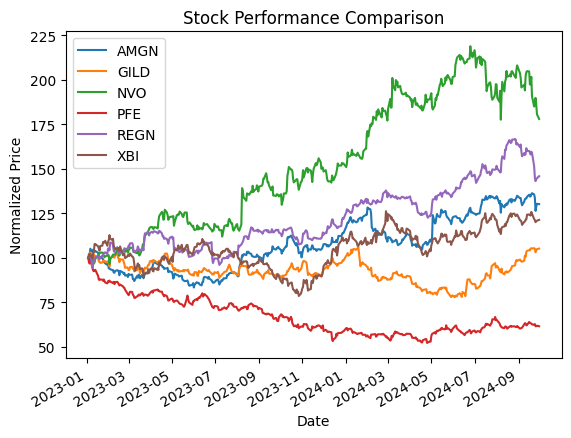

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

def calculate_returns(prices):
    return prices.pct_change()

def calculate_metrics(returns, prices):
    metrics = pd.DataFrame()
    metrics['Annualized Return'] = returns.mean() * 252
    metrics['Volatility'] = returns.std() * np.sqrt(252)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Volatility']
    metrics['Max Drawdown'] = (prices / prices.cummax() - 1).min()
    return metrics

def analyze_financials(tickers):
    financials = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        financial_data = stock.financials.T
        if not financial_data.empty:
            financials[ticker] = financial_data.mean().to_dict()  # Average financial metrics
    return pd.DataFrame(financials).T

def identify_short_candidates(metrics, financials):
    short_candidates = pd.DataFrame()
    short_candidates['Low Returns'] = metrics['Annualized Return'] < metrics['Annualized Return'].median()
    short_candidates['High Volatility'] = metrics['Volatility'] > metrics['Volatility'].median()
    short_candidates['Negative Sharpe'] = metrics['Sharpe Ratio'] < 0
    short_candidates['Large Drawdown'] = metrics['Max Drawdown'] < metrics['Max Drawdown'].median()
    
    # Automatically evaluate financial metrics without hardcoding
    for column in financials.columns:
        if financials[column].dtype in [np.float64, np.int64]:
            short_candidates[f'High {column}'] = financials[column] > financials[column].median()
    
    short_candidates['Short Score'] = short_candidates.sum(axis=1)
    return short_candidates.sort_values('Short Score', ascending=False)

def rank_short_candidates(short_candidates, metrics, financials):
    # Combine all relevant metrics
    ranking_data = pd.concat([short_candidates['Short Score'],
                              -metrics['Annualized Return'],  # Negative because lower returns are better for shorting
                              metrics['Volatility'],
                              -metrics['Sharpe Ratio'],  # Negative because lower Sharpe is better for shorting
                              -metrics['Max Drawdown']], axis=1)

    # Normalize the data
    normalized_data = (ranking_data - ranking_data.mean()) / ranking_data.std()
    
    # Calculate the overall score (higher is better for shorting)
    overall_score = normalized_data.mean(axis=1)
    
    # Rank the stocks based on the overall score
    ranked_stocks = overall_score.sort_values(ascending=False)
    
    return ranked_stocks

# Main analysis
tickers = ['NVO', 'PFE', 'AMGN', 'REGN', 'GILD', 'XBI']
start_date = '2023-01-01'
end_date = '2024-10-01'

prices = get_stock_data(tickers, start_date, end_date)
returns = calculate_returns(prices)
metrics = calculate_metrics(returns, prices)
financials = analyze_financials(tickers[:-1])  # Exclude XBI from financials
short_candidates = identify_short_candidates(metrics.iloc[:-1], financials)  # Exclude XBI from short candidates

# Rank the short candidates
ranked_shorts = rank_short_candidates(short_candidates, metrics.iloc[:-1], financials)

print("Ranked Short Candidates (Best to Worst for Shorting):")
print(ranked_shorts)

print("\nDetailed Metrics for Each Stock:")
for ticker in ranked_shorts.index:
    print(f"\n{ticker}:")
    print(f"Short Score: {short_candidates.loc[ticker, 'Short Score']}")
    print(f"Annualized Return: {metrics.loc[ticker, 'Annualized Return']:.2%}")
    print(f"Volatility: {metrics.loc[ticker, 'Volatility']:.2%}")
    print(f"Sharpe Ratio: {metrics.loc[ticker, 'Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: {metrics.loc[ticker, 'Max Drawdown']:.2%}")
    for column in financials.columns:
        print(f"{column}: {financials.loc[ticker, column]:.2f}")

# Visualize stock performance
plt.figure(figsize=(12, 6))
(prices / prices.iloc[0] * 100).plot()
plt.title('Stock Performance Comparison')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


[*********************100%***********************]  6 of 6 completed


Performance Metrics:
        Annualized Return  Volatility  Sharpe Ratio  Max Drawdown  Beta
Ticker                                                                 
AMGN             0.178804    0.231487      0.772412     -0.207125   NaN
GILD             0.055039    0.225520      0.244053     -0.265898   NaN
NVO              0.381066    0.313861      1.214126     -0.188415   NaN
PFE             -0.252111    0.230386     -1.094296     -0.477107   NaN
REGN             0.242203    0.219647      1.102692     -0.166075   NaN
XBI              0.148802    0.272854      0.545356     -0.302792   NaN

Financial Metrics:
       P/E Ratio  Debt to Equity  Current Ratio      ROE  Profit Margin
NVO    40.741497          50.710          0.945  0.88572        0.34844
PFE          NaN          79.407          0.863 -0.02737       -0.04704
AMGN   55.872635        1057.300          1.264  0.49268        0.10118
REGN   26.846216           9.585          5.439  0.16551        0.32038
GILD  103.719520       

<Figure size 1200x600 with 0 Axes>

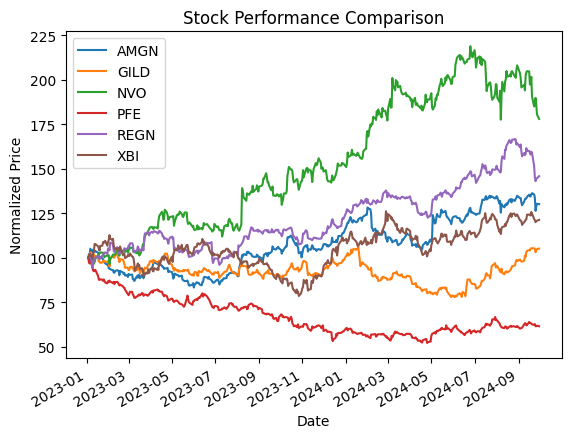

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

def calculate_returns(prices):
    return prices.pct_change()

def calculate_metrics(returns, prices):
    metrics = pd.DataFrame()
    metrics['Annualized Return'] = returns.mean() * 252
    metrics['Volatility'] = returns.std() * np.sqrt(252)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Volatility']
    metrics['Max Drawdown'] = (prices / prices.cummax() - 1).min()
    metrics['Beta'] = returns.apply(lambda x: stats.linregress(returns['XBI'], x)[0])
    return metrics

def analyze_financials(tickers):
    financials = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        financials[ticker] = {
            'P/E Ratio': stock.info.get('trailingPE', np.nan),
            'Debt to Equity': stock.info.get('debtToEquity', np.nan),
            'Current Ratio': stock.info.get('currentRatio', np.nan),
            'ROE': stock.info.get('returnOnEquity', np.nan),
            'Profit Margin': stock.info.get('profitMargins', np.nan)
        }
    return pd.DataFrame(financials).T

def identify_short_candidates(metrics, financials):
    short_candidates = pd.DataFrame()
    short_candidates['Low Returns'] = metrics['Annualized Return'] < metrics['Annualized Return'].median()
    short_candidates['High Volatility'] = metrics['Volatility'] > metrics['Volatility'].median()
    short_candidates['Negative Sharpe'] = metrics['Sharpe Ratio'] < 0
    short_candidates['Large Drawdown'] = metrics['Max Drawdown'] < metrics['Max Drawdown'].median()
    short_candidates['High P/E'] = financials['P/E Ratio'] > financials['P/E Ratio'].median()
    short_candidates['High Debt'] = financials['Debt to Equity'] > financials['Debt to Equity'].median()
    short_candidates['Low Current Ratio'] = financials['Current Ratio'] < 1
    short_candidates['Low ROE'] = financials['ROE'] < financials['ROE'].median()
    short_candidates['Low Profit Margin'] = financials['Profit Margin'] < financials['Profit Margin'].median()
    short_candidates['Short Score'] = short_candidates.sum(axis=1)
    return short_candidates.sort_values('Short Score', ascending=False)

# Main analysis
tickers = ['NVO', 'PFE', 'AMGN', 'REGN', 'GILD', 'XBI']
start_date = '2023-01-01'
end_date = '2024-10-01'

prices = get_stock_data(tickers, start_date, end_date)
returns = calculate_returns(prices)
metrics = calculate_metrics(returns, prices)
financials = analyze_financials(tickers[:-1])  # Exclude XBI from financials
short_candidates = identify_short_candidates(metrics.iloc[:-1], financials)  # Exclude XBI from short candidates

print("Performance Metrics:")
print(metrics)
print("\nFinancial Metrics:")
print(financials)
print("\nShort Candidates Analysis:")
print(short_candidates)

# Visualize stock performance
plt.figure(figsize=(12, 6))
(prices / prices.iloc[0] * 100).plot()
plt.title('Stock Performance Comparison')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    print("Columns in the downloaded data:", data.columns)
    print("Data types of columns:", data.dtypes)
    return data

def calculate_returns(data):
    price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    return data[price_col].pct_change()

def calculate_metrics(data, returns):
    metrics = pd.DataFrame()

    for ticker in returns.columns:
        ticker_metrics = pd.Series(dtype='float64')
        
        # Performance metrics
        ticker_metrics['Annualized Return'] = returns[ticker].mean() * 252
        ticker_metrics['Volatility'] = returns[ticker].std() * np.sqrt(252)
        ticker_metrics['Sharpe Ratio'] = ticker_metrics['Annualized Return'] / ticker_metrics['Volatility']
        ticker_metrics['Max Drawdown'] = (data['Adj Close'][ticker] / data['Adj Close'][ticker].cummax() - 1).min()
        ticker_metrics['Beta'] = stats.linregress(returns['XBI'], returns[ticker])[0]
        
        # Volume metrics
        ticker_metrics['Avg Volume'] = data['Volume'][ticker].mean()
        ticker_metrics['Volume Trend'] = data['Volume'][ticker].pct_change().mean()
        
        # Momentum indicators
        ticker_metrics['RSI'] = calculate_rsi(data['Adj Close'][ticker])
        ticker_metrics['MACD'] = calculate_macd(data['Adj Close'][ticker])
        
        # Volatility indicators
        ticker_data = pd.DataFrame({
            'High': data['High'][ticker],
            'Low': data['Low'][ticker],
            'Close': data['Close'][ticker]
        })
        ticker_metrics['ATR'] = calculate_atr(ticker_data)
        ticker_metrics['Bollinger Band Width'] = calculate_bbw(data['Adj Close'][ticker])
        
        metrics[ticker] = ticker_metrics

    return metrics.T  # Transpose the DataFrame so that tickers are rows and metrics are columns

def analyze_financials(tickers):
    financials = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info
        financials[ticker] = {
            'P/E Ratio': info.get('trailingPE', np.nan),
            'Forward P/E': info.get('forwardPE', np.nan),
            'PEG Ratio': info.get('pegRatio', np.nan),
            'P/S Ratio': info.get('priceToSalesTrailing12Months', np.nan),
            'P/B Ratio': info.get('priceToBook', np.nan),
            'Debt to Equity': info.get('debtToEquity', np.nan),
            'Current Ratio': info.get('currentRatio', np.nan),
            'Quick Ratio': info.get('quickRatio', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'ROA': info.get('returnOnAssets', np.nan),
            'Profit Margin': info.get('profitMargins', np.nan),
            'Operating Margin': info.get('operatingMargins', np.nan),
            'Gross Margin': info.get('grossMargins', np.nan),
            'Earnings Growth': info.get('earningsGrowth', np.nan),
            'Revenue Growth': info.get('revenueGrowth', np.nan),
            'Free Cash Flow': info.get('freeCashflow', np.nan),
            'Short Ratio': info.get('shortRatio', np.nan),
            'Short % of Float': info.get('shortPercentOfFloat', np.nan)
        }
    df = pd.DataFrame(financials).T
    return df.replace([np.inf, -np.inf], np.nan)

def identify_short_candidates(metrics, financials):
    short_candidates = pd.DataFrame()
    
    # Performance-based criteria
    short_candidates['Low Returns'] = metrics['Annualized Return'] < metrics['Annualized Return'].median()
    short_candidates['High Volatility'] = metrics['Volatility'] > metrics['Volatility'].median()
    short_candidates['Negative Sharpe'] = metrics['Sharpe Ratio'] < 0
    short_candidates['Large Drawdown'] = metrics['Max Drawdown'] < metrics['Max Drawdown'].median()
    short_candidates['High Beta'] = metrics['Beta'] > 1
    
    # Volume-based criteria
    short_candidates['Decreasing Volume'] = metrics['Volume Trend'] < 0
    
    # Momentum-based criteria
    short_candidates['Overbought RSI'] = metrics['RSI'] > 70
    short_candidates['Bearish MACD'] = metrics['MACD'] < 0
    
    # Volatility-based criteria
    short_candidates['High ATR'] = metrics['ATR'] > metrics['ATR'].median()
    short_candidates['Wide Bollinger Bands'] = metrics['Bollinger Band Width'] > metrics['Bollinger Band Width'].median()
    
    # Valuation-based criteria
    short_candidates['High P/E'] = financials['P/E Ratio'].gt(financials['P/E Ratio'].median())
    short_candidates['High Forward P/E'] = financials['Forward P/E'].gt(financials['Forward P/E'].median())
    short_candidates['High PEG'] = financials['PEG Ratio'].gt(financials['PEG Ratio'].median())
    short_candidates['High P/S'] = financials['P/S Ratio'].gt(financials['P/S Ratio'].median())
    short_candidates['High P/B'] = financials['P/B Ratio'].gt(financials['P/B Ratio'].median())
    
    # Financial health criteria
    short_candidates['High Debt'] = financials['Debt to Equity'].gt(financials['Debt to Equity'].median())
    short_candidates['Low Current Ratio'] = financials['Current Ratio'] < 1
    short_candidates['Low Quick Ratio'] = financials['Quick Ratio'] < 1
    
    # Profitability criteria
    short_candidates['Low ROE'] = financials['ROE'].lt(financials['ROE'].median())
    short_candidates['Low ROA'] = financials['ROA'].lt(financials['ROA'].median())
    short_candidates['Low Profit Margin'] = financials['Profit Margin'].lt(financials['Profit Margin'].median())
    short_candidates['Low Operating Margin'] = financials['Operating Margin'].lt(financials['Operating Margin'].median())
    
    # Growth criteria
    short_candidates['Low Earnings Growth'] = financials['Earnings Growth'].lt(financials['Earnings Growth'].median())
    short_candidates['Low Revenue Growth'] = financials['Revenue Growth'].lt(financials['Revenue Growth'].median())
    
    # Short interest criteria
    short_candidates['High Short Ratio'] = financials['Short Ratio'].gt(financials['Short Ratio'].median())
    short_candidates['High Short % of Float'] = financials['Short % of Float'].gt(financials['Short % of Float'].median())
    
    short_candidates['Short Score'] = short_candidates.sum(axis=1)
    return short_candidates.sort_values('Short Score', ascending=False)

def rank_short_candidates(short_candidates, metrics, financials):
    ranking_data = pd.concat([
        short_candidates['Short Score'],
        -metrics['Annualized Return'],
        metrics['Volatility'],
        -metrics['Sharpe Ratio'],
        -metrics['Max Drawdown'],
        metrics['Beta'],
        -metrics['Volume Trend'],
        metrics['RSI'],
        -metrics['MACD'],
        metrics['ATR'],
        metrics['Bollinger Band Width'],
        financials[['P/E Ratio', 'Forward P/E', 'PEG Ratio', 'P/S Ratio', 'P/B Ratio',
                    'Debt to Equity', 'Current Ratio', 'Quick Ratio', 'ROE', 'ROA',
                    'Profit Margin', 'Operating Margin', 'Gross Margin', 'Earnings Growth',
                    'Revenue Growth', 'Free Cash Flow', 'Short Ratio', 'Short % of Float']]
    ], axis=1)
    
    scaler = StandardScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(ranking_data), columns=ranking_data.columns, index=ranking_data.index)
    
    weights = {
        'Short Score': 2,
        'Annualized Return': 1.5,
        'Volatility': 1,
        'Sharpe Ratio': 1.5,
        'Max Drawdown': 1,
        'Beta': 0.5,
        'Volume Trend': 0.5,
        'RSI': 1,
        'MACD': 1,
        'ATR': 0.5,
        'Bollinger Band Width': 0.5,
        'P/E Ratio': 1,
        'Forward P/E': 1,
        'PEG Ratio': 1,
        'P/S Ratio': 0.5,
        'P/B Ratio': 0.5,
        'Debt to Equity': 1,
        'Current Ratio': 0.5,
        'Quick Ratio': 0.5,
        'ROE': 1,
        'ROA': 1,
        'Profit Margin': 1,
        'Operating Margin': 0.5,
        'Gross Margin': 0.5,
        'Earnings Growth': 1,
        'Revenue Growth': 1,
        'Free Cash Flow': 0.5,
        'Short Ratio': 0.5,
        'Short % of Float': 0.5
    }
    
    weighted_data = normalized_data * pd.Series(weights)
    overall_score = weighted_data.mean(axis=1)
    ranked_stocks = overall_score.sort_values(ascending=False)
    
    return ranked_stocks

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs)).iloc[-1]  # Return only the last value

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return (macd - signal_line).iloc[-1]  # Return only the last value

def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    return true_range.rolling(period).mean().iloc[-1]  # Return only the last value

def calculate_bbw(prices, period=20, num_std=2):
    rolling_mean = prices.rolling(window=period).mean()
    rolling_std = prices.rolling(window=period).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return ((upper_band - lower_band) / rolling_mean).iloc[-1]  # Return only the last value

# Main analysis
#tickers = ['NVO', 'PFE', 'AMGN', 'REGN', 'GILD', 'XBI']
tickers = pd.read_csv("biotech_tickers.csv").Ticker.unique().tolist()
tickers.extend(['XBI'])
start_date = '2023-01-01'
end_date = '2024-10-01'

data = get_stock_data(tickers, start_date, end_date)
returns = calculate_returns(data)
metrics = calculate_metrics(data, returns)
financials = analyze_financials(tickers[:-1])  # Exclude XBI from financials
short_candidates = identify_short_candidates(metrics.iloc[:-1], financials)  # Exclude XBI from short candidates

# Rank the short candidates
ranked_shorts = rank_short_candidates(short_candidates, metrics.iloc[:-1], financials)

print("Ranked Short Candidates (Best to Worst for Shorting):")
print(ranked_shorts)

print("\nDetailed Metrics for Each Stock:")
for ticker in ranked_shorts.index:
    print(f"\n{ticker}:")
    print(f"Short Score: {short_candidates.loc[ticker, 'Short Score']}")
    print(f"Annualized Return: {metrics.loc[ticker, 'Annualized Return']:.2%}")
    print(f"Volatility: {metrics.loc[ticker, 'Volatility']:.2%}")
    print(f"Sharpe Ratio: {metrics.loc[ticker, 'Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: {metrics.loc[ticker, 'Max Drawdown']:.2%}")
    print(f"Beta: {metrics.loc[ticker, 'Beta']:.2f}")
    # print(f"RSI: {metrics.loc[ticker, 'RSI']:.2f}")
    # print(f"MACD: {metrics.loc[ticker, 'MACD']:.2f}")
    # print(f"ATR: {metrics.loc[ticker, 'ATR']:.2f}")
    # print(f"Bollinger Band Width: {metrics.loc[ticker, 'Bollinger Band Width']:.2f}")
    for col in financials.columns:
        print(f"{col}: {financials.loc[ticker, col]:.2f}")

# Visualize stock performance
plt.figure(figsize=(12, 6))
(data['Adj Close'] / data['Adj Close'].iloc[0] * 100).plot()
plt.title('Stock Performance Comparison')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

[                       1%                       ]  5 of 667 completed2024-10-14 16:22:47,074 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2024-10-14 16:22:47,075 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
2024-10-14 16:22:47,079 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[                       1%                       ]  10 of 667 completed2024-10-14 16:22:47,101 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*                      2%                       ]  11 of 667 completed2024-10-14 16:22:47,101 - WARNING - Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[**                     5%                       ]  33 of 667 completed2024-10-14 16:22:47,476 - WARNING - Connecti

Columns in the downloaded data: MultiIndex([('Adj Close', 'AADI'),
            ('Adj Close', 'ABCL'),
            ('Adj Close', 'ABEO'),
            ('Adj Close', 'ABOS'),
            ('Adj Close', 'ABSI'),
            ('Adj Close', 'ABUS'),
            ('Adj Close', 'ABVC'),
            ('Adj Close', 'ABVX'),
            ('Adj Close', 'ACAD'),
            ('Adj Close', 'ACET'),
            ...
            (   'Volume', 'XRTX'),
            (   'Volume', 'XTLB'),
            (   'Volume', 'YMAB'),
            (   'Volume', 'ZBIO'),
            (   'Volume', 'ZLAB'),
            (   'Volume', 'ZNTL'),
            (   'Volume', 'ZURA'),
            (   'Volume', 'ZVRA'),
            (   'Volume', 'ZVSA'),
            (   'Volume', 'ZYME')],
           names=['Price', 'Ticker'], length=4002)
Data types of columns: Price      Ticker
Adj Close  AADI      float64
           ABCL      float64
           ABEO      float64
           ABOS      float64
           ABSI      float64
              

C:\Users\MukeshwaranBaskaran\AppData\Local\Temp\ipykernel_9044\3852936954.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metrics[ticker] = ticker_metrics
C:\Users\MukeshwaranBaskaran\AppData\Local\Temp\ipykernel_9044\3852936954.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metrics[ticker] = ticker_metrics
C:\Users\MukeshwaranBaskaran\AppData\Local\Temp\ipykernel_9044\3852936954.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

TypeError: Cannot convert [40.741497 nan 26.846216 nan nan nan nan nan 16.425943 19.080645 nan nan
 53.234844 159.60976 18.58 nan 70.30476 165.82668 nan 2.0663176 nan nan
 22.62069 nan nan 18.818644 nan 20.910854 nan nan nan nan 45.46329 nan
 116.92857 40.088493 nan nan nan nan nan nan nan nan nan nan nan 33.57353
 nan nan nan nan nan nan nan nan nan 17.04044 nan nan nan nan 78.89474
 36.857143 nan nan nan nan nan nan nan nan nan nan nan nan 4209.0 nan nan
 nan 56.288464 nan 18.194872 44.403435 nan nan nan nan 130.8 nan nan nan
 nan nan nan nan nan nan nan nan nan 2.8154268 nan nan nan nan nan nan nan
 nan nan nan nan nan 11.2372875 nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 10.052631 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 5.9039736 nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan 27.259258 nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 15.275001 nan nan nan nan nan nan nan nan nan 7.122807 nan nan nan nan
 nan nan nan nan nan nan nan 0.13042746 nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 15.0 nan nan nan nan nan
 64.85714 nan nan nan nan nan nan nan nan nan 5.952381 nan nan nan
 6.111111 nan nan nan nan nan nan nan nan nan nan nan nan 4.666667 nan nan
 nan nan nan nan nan nan 4.2915387 nan nan nan nan nan nan 7.2666664 nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 3.6176472 nan nan 34.26923 nan nan nan nan
 nan nan nan nan nan nan nan 48.285717 nan nan nan nan nan nan nan nan nan
 nan nan nan 5.0108695 nan nan nan nan nan 18.166668 nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 0.10935564 nan nan nan 1.1686046 nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 1.0 nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 2.703125 nan nan
 nan nan nan 0.26304802 nan nan nan nan nan nan nan nan nan nan nan nan
 nan 0.18753779 nan nan nan nan nan nan nan 0.0025993884 nan nan nan nan
 nan nan nan nan nan nan 0.30286476 nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 0.27458614 nan nan nan nan 0.0055020037 nan nan nan nan nan
 nan nan nan nan nan nan nan nan 'Infinity' nan nan 0.05402882 nan nan nan
 nan nan nan nan 0.001991903 0.095791005 nan nan nan 0.34065932 nan nan
 nan nan nan nan nan nan nan nan nan 0.0069792615 0.0064342036 nan nan nan
 nan nan] to numeric

In [61]:
financials

,P/E Ratio,Forward P/E,PEG Ratio,P/S Ratio,P/B Ratio,Debt to Equity,Current Ratio,Quick Ratio,ROE,ROA,Profit Margin,Operating Margin,Gross Margin,Earnings Growth,Revenue Growth,Free Cash Flow,Short Ratio,Short % of Float
NVO,40.741497,28.587112,84.96,2.069723,4.745266,50.71,0.945,0.739,0.88572,0.22798,0.34844,0.4648,0.84528,0.039,0.253,54488375296.0,1.82,0.0022
VRTX,NaN,27.3292,118.39,12.104883,8.466549,6.318,2.521,2.101,-0.0324,0.12963,-0.04739,0.35338,0.53649,NaN,0.061,2893287424.0,3.91,0.0158
REGN,26.846216,20.972912,2.15,8.288608,3.879965,9.585,5.439,4.425,0.16551,0.07615,0.32038,0.30828,0.53272,0.46,0.123,2090912512.0,2.78,0.0166
ALNY,NaN,-186.39474,0.66,15.514764,NaN,NaN,3.007,2.781,NaN,0.01731,-0.03111,0.07368,0.86998,NaN,1.07,424344512.0,5.35,0.0404
ARGX,NaN,84.666664,-19.57,19.58453,7.625809,0.797,8.534,7.521,-0.0574,-0.05511,-0.12313,-0.08978,0.3255,NaN,0.742,-223878000.0,6.83,0.0334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GNPX,NaN,-0.156789,NaN,NaN,0.201059,NaN,1.945,1.088,-3.18877,-1.45941,NaN,NaN,NaN,NaN,NaN,-12445628.0,0.09,0.0316
WINT,NaN,-0.319249,NaN,NaN,0.115196,87.894,0.235,0.205,-1.50801,-0.44755,NaN,NaN,NaN,NaN,NaN,-9014250.0,0.07,0.0613
SPRC,NaN,NaN,NaN,0.785327,0.020262,0.793,4.102,3.414,-0.73372,-0.33122,-1.77909,-3.09372,0.76276,NaN,-0.327,-5922750.0,0.51,0.0803
ADTX,NaN,-0.097431,NaN,0.44941,0.00835,126.761,0.073,0.024,-34.93626,-1.17605,NaN,-134.97112,-0.46092,NaN,-0.8,-13256582.0,0.09,0.0427
